# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

/tmp/ipykernel_203063/3741198026.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
/tmp/ipykernel_203063/3741198026.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


/tmp/ipykernel_203063/1098455523.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


/tmp/ipykernel_203063/2688850719.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
/tmp/ipykernel_203063/2688850719.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


/tmp/ipykernel_203063/3211748656.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
/tmp/ipykernel_203063/3211748656.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
/tmp/ipyker

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [11]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 691.126734
Epoch 1, loss: 717.019993
Epoch 2, loss: 742.517739
Epoch 3, loss: 767.434835
Epoch 4, loss: 781.312402
Epoch 5, loss: 751.616065
Epoch 6, loss: 741.137412
Epoch 7, loss: 799.083768
Epoch 8, loss: 912.039534
Epoch 9, loss: 947.064208


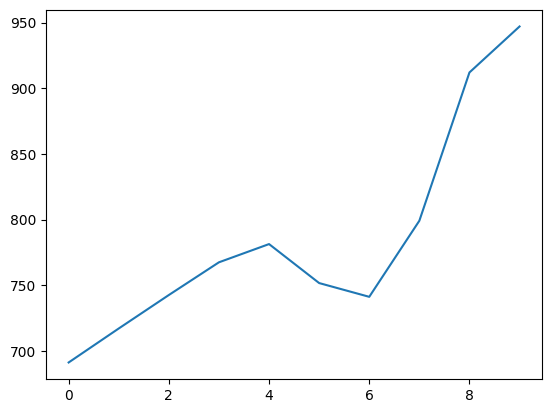

In [12]:
# let's look at the loss history!
plt.plot(loss_history);

In [13]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.146
Epoch 0, loss: 713.445531
Epoch 1, loss: 719.195132
Epoch 2, loss: 713.910978
Epoch 3, loss: 727.410103
Epoch 4, loss: 749.326307
Epoch 5, loss: 837.423965
Epoch 6, loss: 1018.506335
Epoch 7, loss: 1390.977540
Epoch 8, loss: 1067.984933
Epoch 9, loss: 1019.505285
Epoch 10, loss: 1001.378783
Epoch 11, loss: 937.158608
Epoch 12, loss: 914.534530
Epoch 13, loss: 871.930016
Epoch 14, loss: 790.971990
Epoch 15, loss: 797.761611
Epoch 16, loss: 842.667193
Epoch 17, loss: 909.083294
Epoch 18, loss: 977.683611
Epoch 19, loss: 732.855889
Epoch 20, loss: 790.471729
Epoch 21, loss: 796.253121
Epoch 22, loss: 892.691976
Epoch 23, loss: 1015.739307
Epoch 24, loss: 791.692767
Epoch 25, loss: 798.720621
Epoch 26, loss: 943.640671
Epoch 27, loss: 901.906725
Epoch 28, loss: 874.624438
Epoch 29, loss: 854.149489
Epoch 30, loss: 866.985139
Epoch 31, loss: 943.287905
Epoch 32, loss: 1012.480541
Epoch 33, loss: 970.016200
Epoch 34, loss: 896.244224
Epoch 35, loss: 977.069521
Epoch 36, loss

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [14]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
reg_strengths =  [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

best_classifier = None
best_val_accuracy = 0

for learning_rate in learning_rates:
    for reg in reg_strengths:
        classifier.fit(train_X, train_y, epochs=num_epochs,
                       learning_rate=learning_rate, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier        

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 740.387932
Epoch 1, loss: 847.208621
Epoch 2, loss: 1010.637514
Epoch 3, loss: 776.461506
Epoch 4, loss: 874.457524
Epoch 5, loss: 725.899605
Epoch 6, loss: 775.054967
Epoch 7, loss: 853.419025
Epoch 8, loss: 815.457579
Epoch 9, loss: 790.217594
Epoch 10, loss: 751.981369
Epoch 11, loss: 775.887464
Epoch 12, loss: 840.439449
Epoch 13, loss: 742.696129
Epoch 14, loss: 719.953322
Epoch 15, loss: 686.499639
Epoch 16, loss: 686.279909
Epoch 17, loss: 687.659711
Epoch 18, loss: 775.199171
Epoch 19, loss: 979.279375
Epoch 20, loss: 856.181311
Epoch 21, loss: 840.301917
Epoch 22, loss: 896.102619
Epoch 23, loss: 860.019078
Epoch 24, loss: 931.519107
Epoch 25, loss: 1065.703835
Epoch 26, loss: 892.659832
Epoch 27, loss: 881.905360
Epoch 28, loss: 831.024171
Epoch 29, loss: 858.549257
Epoch 30, loss: 879.232204
Epoch 31, loss: 996.260758
Epoch 32, loss: 875.779260
Epoch 33, loss: 857.976496
Epoch 34, loss: 741.834647
Epoch 35, loss: 812.117248
Epoch 36, loss: 784.818838
Epoch 37,

Epoch 161, loss: 766.126801
Epoch 162, loss: 785.262523
Epoch 163, loss: 855.562659
Epoch 164, loss: 912.248324
Epoch 165, loss: 740.747643
Epoch 166, loss: 780.270055
Epoch 167, loss: 877.787878
Epoch 168, loss: 785.821462
Epoch 169, loss: 896.385136
Epoch 170, loss: 833.635157
Epoch 171, loss: 854.550442
Epoch 172, loss: 805.406861
Epoch 173, loss: 804.441405
Epoch 174, loss: 939.167924
Epoch 175, loss: 1026.144776
Epoch 176, loss: 846.325089
Epoch 177, loss: 954.331859
Epoch 178, loss: 954.033055
Epoch 179, loss: 907.972965
Epoch 180, loss: 804.977417
Epoch 181, loss: 737.150963
Epoch 182, loss: 811.862428
Epoch 183, loss: 716.721052
Epoch 184, loss: 707.321871
Epoch 185, loss: 694.894193
Epoch 186, loss: 642.742018
Epoch 187, loss: 667.935122
Epoch 188, loss: 716.796908
Epoch 189, loss: 753.881068
Epoch 190, loss: 726.651642
Epoch 191, loss: 736.943457
Epoch 192, loss: 816.798730
Epoch 193, loss: 792.373222
Epoch 194, loss: 792.706597
Epoch 195, loss: 722.951300
Epoch 196, loss: 77

Epoch 105, loss: 829.928913
Epoch 106, loss: 791.143717
Epoch 107, loss: 783.216933
Epoch 108, loss: 780.582440
Epoch 109, loss: 824.968503
Epoch 110, loss: 812.528503
Epoch 111, loss: 892.116995
Epoch 112, loss: 829.293843
Epoch 113, loss: 848.542314
Epoch 114, loss: 799.523303
Epoch 115, loss: 735.193296
Epoch 116, loss: 702.934028
Epoch 117, loss: 712.702531
Epoch 118, loss: 733.755426
Epoch 119, loss: 740.238632
Epoch 120, loss: 747.750101
Epoch 121, loss: 798.200967
Epoch 122, loss: 846.638228
Epoch 123, loss: 828.874995
Epoch 124, loss: 765.925874
Epoch 125, loss: 730.828486
Epoch 126, loss: 745.648075
Epoch 127, loss: 768.292119
Epoch 128, loss: 748.223581
Epoch 129, loss: 777.483842
Epoch 130, loss: 948.253918
Epoch 131, loss: 998.735833
Epoch 132, loss: 806.099453
Epoch 133, loss: 765.597401
Epoch 134, loss: 951.242226
Epoch 135, loss: 850.918115
Epoch 136, loss: 863.538394
Epoch 137, loss: 835.274738
Epoch 138, loss: 746.789753
Epoch 139, loss: 816.676788
Epoch 140, loss: 975

Epoch 62, loss: 618.909459
Epoch 63, loss: 634.328425
Epoch 64, loss: 627.629363
Epoch 65, loss: 599.709793
Epoch 66, loss: 618.421330
Epoch 67, loss: 630.638101
Epoch 68, loss: 658.110767
Epoch 69, loss: 624.932821
Epoch 70, loss: 632.550464
Epoch 71, loss: 648.039764
Epoch 72, loss: 621.939216
Epoch 73, loss: 618.090512
Epoch 74, loss: 617.806501
Epoch 75, loss: 644.291840
Epoch 76, loss: 608.407310
Epoch 77, loss: 648.720431
Epoch 78, loss: 632.490867
Epoch 79, loss: 629.746718
Epoch 80, loss: 635.034920
Epoch 81, loss: 627.621296
Epoch 82, loss: 628.739763
Epoch 83, loss: 634.190108
Epoch 84, loss: 646.794037
Epoch 85, loss: 616.600495
Epoch 86, loss: 639.495141
Epoch 87, loss: 622.682149
Epoch 88, loss: 611.088666
Epoch 89, loss: 639.901756
Epoch 90, loss: 616.324560
Epoch 91, loss: 616.662804
Epoch 92, loss: 608.241625
Epoch 93, loss: 604.716926
Epoch 94, loss: 620.027012
Epoch 95, loss: 624.187727
Epoch 96, loss: 639.936257
Epoch 97, loss: 650.844014
Epoch 98, loss: 625.752728
E

Epoch 14, loss: 601.811923
Epoch 15, loss: 615.223245
Epoch 16, loss: 633.478891
Epoch 17, loss: 616.894071
Epoch 18, loss: 609.279909
Epoch 19, loss: 625.180313
Epoch 20, loss: 600.972884
Epoch 21, loss: 635.259317
Epoch 22, loss: 632.349817
Epoch 23, loss: 598.227793
Epoch 24, loss: 615.067671
Epoch 25, loss: 613.173422
Epoch 26, loss: 622.547060
Epoch 27, loss: 605.256051
Epoch 28, loss: 615.563678
Epoch 29, loss: 613.374954
Epoch 30, loss: 622.354068
Epoch 31, loss: 626.245464
Epoch 32, loss: 607.829998
Epoch 33, loss: 631.432083
Epoch 34, loss: 622.059890
Epoch 35, loss: 610.794261
Epoch 36, loss: 625.161245
Epoch 37, loss: 623.913619
Epoch 38, loss: 622.670587
Epoch 39, loss: 625.688797
Epoch 40, loss: 594.698298
Epoch 41, loss: 617.328778
Epoch 42, loss: 623.281097
Epoch 43, loss: 614.785275
Epoch 44, loss: 620.037316
Epoch 45, loss: 614.399729
Epoch 46, loss: 616.974989
Epoch 47, loss: 601.488234
Epoch 48, loss: 605.531844
Epoch 49, loss: 610.484597
Epoch 50, loss: 601.910836
E

Epoch 165, loss: 606.213347
Epoch 166, loss: 590.230767
Epoch 167, loss: 572.816907
Epoch 168, loss: 626.662875
Epoch 169, loss: 580.475533
Epoch 170, loss: 614.831253
Epoch 171, loss: 612.639608
Epoch 172, loss: 628.346272
Epoch 173, loss: 608.726120
Epoch 174, loss: 630.238018
Epoch 175, loss: 630.160111
Epoch 176, loss: 612.812229
Epoch 177, loss: 600.861154
Epoch 178, loss: 588.330410
Epoch 179, loss: 606.738718
Epoch 180, loss: 610.324824
Epoch 181, loss: 609.836276
Epoch 182, loss: 601.479174
Epoch 183, loss: 614.753355
Epoch 184, loss: 604.297552
Epoch 185, loss: 617.041549
Epoch 186, loss: 608.785005
Epoch 187, loss: 611.480409
Epoch 188, loss: 594.152819
Epoch 189, loss: 609.159784
Epoch 190, loss: 611.484982
Epoch 191, loss: 634.734989
Epoch 192, loss: 616.532334
Epoch 193, loss: 608.943165
Epoch 194, loss: 599.071442
Epoch 195, loss: 618.497488
Epoch 196, loss: 595.112418
Epoch 197, loss: 614.379846
Epoch 198, loss: 633.063482
Epoch 199, loss: 630.831104
Epoch 0, loss: 612.8

Epoch 113, loss: 599.672702
Epoch 114, loss: 604.795342
Epoch 115, loss: 580.647944
Epoch 116, loss: 602.226956
Epoch 117, loss: 604.226108
Epoch 118, loss: 624.929117
Epoch 119, loss: 633.844842
Epoch 120, loss: 601.690933
Epoch 121, loss: 616.660084
Epoch 122, loss: 613.039327
Epoch 123, loss: 606.187501
Epoch 124, loss: 598.305243
Epoch 125, loss: 628.148226
Epoch 126, loss: 602.511670
Epoch 127, loss: 580.443547
Epoch 128, loss: 597.065073
Epoch 129, loss: 618.904277
Epoch 130, loss: 592.397215
Epoch 131, loss: 588.673737
Epoch 132, loss: 599.122447
Epoch 133, loss: 591.254758
Epoch 134, loss: 599.470301
Epoch 135, loss: 612.430199
Epoch 136, loss: 598.692108
Epoch 137, loss: 593.790736
Epoch 138, loss: 618.103172
Epoch 139, loss: 612.583139
Epoch 140, loss: 599.480580
Epoch 141, loss: 599.564420
Epoch 142, loss: 614.059631
Epoch 143, loss: 601.718825
Epoch 144, loss: 609.246144
Epoch 145, loss: 625.437282
Epoch 146, loss: 599.824240
Epoch 147, loss: 601.158669
Epoch 148, loss: 565

Epoch 74, loss: 612.394812
Epoch 75, loss: 630.332792
Epoch 76, loss: 610.451761
Epoch 77, loss: 591.045913
Epoch 78, loss: 602.141522
Epoch 79, loss: 609.884685
Epoch 80, loss: 615.817977
Epoch 81, loss: 617.873959
Epoch 82, loss: 583.943880
Epoch 83, loss: 589.102583
Epoch 84, loss: 588.253428
Epoch 85, loss: 584.188050
Epoch 86, loss: 604.458036
Epoch 87, loss: 617.458544
Epoch 88, loss: 604.740874
Epoch 89, loss: 583.941417
Epoch 90, loss: 613.152872
Epoch 91, loss: 626.113448
Epoch 92, loss: 621.496504
Epoch 93, loss: 621.414573
Epoch 94, loss: 608.361378
Epoch 95, loss: 606.829136
Epoch 96, loss: 616.257038
Epoch 97, loss: 606.860431
Epoch 98, loss: 599.879695
Epoch 99, loss: 595.411678
Epoch 100, loss: 592.859502
Epoch 101, loss: 605.246163
Epoch 102, loss: 605.958816
Epoch 103, loss: 613.349200
Epoch 104, loss: 589.498962
Epoch 105, loss: 636.344632
Epoch 106, loss: 598.889365
Epoch 107, loss: 625.711878
Epoch 108, loss: 590.013582
Epoch 109, loss: 649.376139
Epoch 110, loss: 6

Epoch 20, loss: 575.479869
Epoch 21, loss: 610.298618
Epoch 22, loss: 588.293244
Epoch 23, loss: 591.218897
Epoch 24, loss: 603.743696
Epoch 25, loss: 595.987291
Epoch 26, loss: 606.855882
Epoch 27, loss: 604.880314
Epoch 28, loss: 611.506739
Epoch 29, loss: 608.384593
Epoch 30, loss: 601.593158
Epoch 31, loss: 617.088073
Epoch 32, loss: 625.322046
Epoch 33, loss: 602.681882
Epoch 34, loss: 610.888667
Epoch 35, loss: 600.256949
Epoch 36, loss: 629.566589
Epoch 37, loss: 612.559528
Epoch 38, loss: 606.993084
Epoch 39, loss: 616.823045
Epoch 40, loss: 584.631503
Epoch 41, loss: 609.511925
Epoch 42, loss: 598.817941
Epoch 43, loss: 605.772579
Epoch 44, loss: 599.407200
Epoch 45, loss: 621.157803
Epoch 46, loss: 614.666673
Epoch 47, loss: 599.835260
Epoch 48, loss: 603.520754
Epoch 49, loss: 632.250074
Epoch 50, loss: 598.625111
Epoch 51, loss: 612.566361
Epoch 52, loss: 629.310083
Epoch 53, loss: 600.425336
Epoch 54, loss: 600.037418
Epoch 55, loss: 631.813249
Epoch 56, loss: 594.016462
E

Epoch 160, loss: 601.534753
Epoch 161, loss: 609.000502
Epoch 162, loss: 619.068768
Epoch 163, loss: 608.493840
Epoch 164, loss: 604.997510
Epoch 165, loss: 624.466211
Epoch 166, loss: 623.538682
Epoch 167, loss: 590.834011
Epoch 168, loss: 602.629752
Epoch 169, loss: 625.577694
Epoch 170, loss: 608.734485
Epoch 171, loss: 600.835859
Epoch 172, loss: 613.965596
Epoch 173, loss: 626.722809
Epoch 174, loss: 619.745291
Epoch 175, loss: 601.928190
Epoch 176, loss: 600.752164
Epoch 177, loss: 600.989726
Epoch 178, loss: 613.183379
Epoch 179, loss: 604.353865
Epoch 180, loss: 590.693376
Epoch 181, loss: 608.647090
Epoch 182, loss: 600.493134
Epoch 183, loss: 625.488356
Epoch 184, loss: 622.525441
Epoch 185, loss: 607.044335
Epoch 186, loss: 614.326410
Epoch 187, loss: 603.115378
Epoch 188, loss: 611.224015
Epoch 189, loss: 617.090014
Epoch 190, loss: 597.024179
Epoch 191, loss: 596.952084
Epoch 192, loss: 603.978946
Epoch 193, loss: 609.770916
Epoch 194, loss: 598.505838
Epoch 195, loss: 632

Epoch 105, loss: 603.842320
Epoch 106, loss: 614.566099
Epoch 107, loss: 596.904346
Epoch 108, loss: 612.692087
Epoch 109, loss: 597.454478
Epoch 110, loss: 596.395880
Epoch 111, loss: 581.380084
Epoch 112, loss: 610.798963
Epoch 113, loss: 629.680916
Epoch 114, loss: 601.426480
Epoch 115, loss: 603.388645
Epoch 116, loss: 625.648627
Epoch 117, loss: 597.549076
Epoch 118, loss: 598.299893
Epoch 119, loss: 608.878333
Epoch 120, loss: 587.408034
Epoch 121, loss: 612.239395
Epoch 122, loss: 627.390870
Epoch 123, loss: 609.433520
Epoch 124, loss: 586.122366
Epoch 125, loss: 604.513090
Epoch 126, loss: 626.022144
Epoch 127, loss: 598.084542
Epoch 128, loss: 625.802171
Epoch 129, loss: 633.946996
Epoch 130, loss: 610.829713
Epoch 131, loss: 627.628968
Epoch 132, loss: 596.987117
Epoch 133, loss: 591.422144
Epoch 134, loss: 614.850984
Epoch 135, loss: 608.810455
Epoch 136, loss: 617.841222
Epoch 137, loss: 617.811787
Epoch 138, loss: 611.552619
Epoch 139, loss: 598.057656
Epoch 140, loss: 606

Epoch 11, loss: 583.489321
Epoch 12, loss: 627.854182
Epoch 13, loss: 616.446353
Epoch 14, loss: 580.914571
Epoch 15, loss: 619.980648
Epoch 16, loss: 590.632424
Epoch 17, loss: 602.637075
Epoch 18, loss: 603.168278
Epoch 19, loss: 592.666525
Epoch 20, loss: 606.770337
Epoch 21, loss: 601.025635
Epoch 22, loss: 616.141523
Epoch 23, loss: 603.808689
Epoch 24, loss: 587.830344
Epoch 25, loss: 611.358769
Epoch 26, loss: 605.526229
Epoch 27, loss: 601.862292
Epoch 28, loss: 618.547693
Epoch 29, loss: 631.474409
Epoch 30, loss: 619.358706
Epoch 31, loss: 614.686308
Epoch 32, loss: 608.199907
Epoch 33, loss: 577.903957
Epoch 34, loss: 604.319765
Epoch 35, loss: 614.750240
Epoch 36, loss: 604.242423
Epoch 37, loss: 595.686488
Epoch 38, loss: 600.608428
Epoch 39, loss: 618.184179
Epoch 40, loss: 610.127186
Epoch 41, loss: 589.339300
Epoch 42, loss: 621.691661
Epoch 43, loss: 611.078135
Epoch 44, loss: 601.215211
Epoch 45, loss: 625.400180
Epoch 46, loss: 599.617335
Epoch 47, loss: 622.185802
E

Epoch 151, loss: 628.984718
Epoch 152, loss: 616.026482
Epoch 153, loss: 631.883639
Epoch 154, loss: 626.635198
Epoch 155, loss: 625.503366
Epoch 156, loss: 610.569752
Epoch 157, loss: 605.003575
Epoch 158, loss: 598.848353
Epoch 159, loss: 604.356909
Epoch 160, loss: 598.838080
Epoch 161, loss: 591.745781
Epoch 162, loss: 631.476165
Epoch 163, loss: 603.885405
Epoch 164, loss: 613.145026
Epoch 165, loss: 610.476256
Epoch 166, loss: 601.608108
Epoch 167, loss: 612.795370
Epoch 168, loss: 614.028528
Epoch 169, loss: 604.622503
Epoch 170, loss: 595.460672
Epoch 171, loss: 620.177918
Epoch 172, loss: 598.348468
Epoch 173, loss: 611.907502
Epoch 174, loss: 597.978500
Epoch 175, loss: 651.374647
Epoch 176, loss: 607.162049
Epoch 177, loss: 601.809639
Epoch 178, loss: 603.885197
Epoch 179, loss: 616.781791
Epoch 180, loss: 605.746004
Epoch 181, loss: 600.168477
Epoch 182, loss: 595.881404
Epoch 183, loss: 607.604948
Epoch 184, loss: 607.796241
Epoch 185, loss: 601.675366
Epoch 186, loss: 600

Epoch 83, loss: 607.890738
Epoch 84, loss: 593.380216
Epoch 85, loss: 604.372105
Epoch 86, loss: 611.604986
Epoch 87, loss: 619.795793
Epoch 88, loss: 613.143516
Epoch 89, loss: 611.126923
Epoch 90, loss: 599.233776
Epoch 91, loss: 610.728875
Epoch 92, loss: 623.697320
Epoch 93, loss: 603.956581
Epoch 94, loss: 601.759893
Epoch 95, loss: 608.217249
Epoch 96, loss: 610.707516
Epoch 97, loss: 583.533770
Epoch 98, loss: 621.440863
Epoch 99, loss: 620.375363
Epoch 100, loss: 599.793517
Epoch 101, loss: 593.662360
Epoch 102, loss: 628.657458
Epoch 103, loss: 621.848309
Epoch 104, loss: 608.126759
Epoch 105, loss: 612.112087
Epoch 106, loss: 603.556931
Epoch 107, loss: 615.010148
Epoch 108, loss: 614.217538
Epoch 109, loss: 611.903393
Epoch 110, loss: 615.252291
Epoch 111, loss: 625.349104
Epoch 112, loss: 622.429411
Epoch 113, loss: 584.759171
Epoch 114, loss: 612.153599
Epoch 115, loss: 599.206670
Epoch 116, loss: 603.402043
Epoch 117, loss: 629.403616
Epoch 118, loss: 611.178390
Epoch 119

Epoch 61, loss: 591.002171
Epoch 62, loss: 597.511804
Epoch 63, loss: 583.251192
Epoch 64, loss: 607.915212
Epoch 65, loss: 617.540142
Epoch 66, loss: 591.317500
Epoch 67, loss: 596.572961
Epoch 68, loss: 613.205582
Epoch 69, loss: 580.646237
Epoch 70, loss: 611.208064
Epoch 71, loss: 624.772826
Epoch 72, loss: 607.856944
Epoch 73, loss: 609.248915
Epoch 74, loss: 596.118779
Epoch 75, loss: 624.096596
Epoch 76, loss: 593.556683
Epoch 77, loss: 588.979636
Epoch 78, loss: 566.230879
Epoch 79, loss: 599.210441
Epoch 80, loss: 620.618550
Epoch 81, loss: 613.070749
Epoch 82, loss: 605.297241
Epoch 83, loss: 591.579219
Epoch 84, loss: 602.164595
Epoch 85, loss: 597.879698
Epoch 86, loss: 636.350891
Epoch 87, loss: 590.162395
Epoch 88, loss: 595.857742
Epoch 89, loss: 626.331758
Epoch 90, loss: 598.275799
Epoch 91, loss: 596.732682
Epoch 92, loss: 595.172642
Epoch 93, loss: 609.493822
Epoch 94, loss: 591.245952
Epoch 95, loss: 604.734659
Epoch 96, loss: 593.056398
Epoch 97, loss: 630.110510
E

In [15]:
best_classifier

# Какой же точности мы добились на тестовых данных?

In [16]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.209000
